### Installs

In [1]:
# ! pip install --quiet -U transformers
! pip install --quiet datasets
!pip install --quiet datasets
!pip install --quiet scikit-learn
!pip install --quiet evaluate
!pip install --quiet sentencepiece
!pip install --quiet -U transformers[torch]
! pip install -U accelerate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 29.3 MB/s eta 0:00:00


### Prelimenaries

In [2]:
import gdown

url = "https://drive.google.com/drive/folders/1B4s1JgxRKWJB4IrRVjE5wWNjM-sNSQT3"
gdown.download_folder(url, output="./", quiet=True, use_cookies=False)

['./dataset/test.csv', './dataset/train.csv', './dataset/validation.csv']

In [3]:
base_dir = './dataset/'
data_files = {"train": base_dir + "train.csv", "validation": base_dir + "validation.csv", "test": base_dir + "test.csv"}

In [4]:
! mkdir results

In [5]:
import random
import numpy as np

import torch
import torch.nn as nn
import sys
import os

from datasets import load_dataset

In [6]:
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

set_seed()

In [7]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [8]:
import logging

# Creating an object
logger = logging.getLogger()

# Setting the threshold of logger to DEBUG
logger.setLevel(logging.INFO)

In [9]:
# General variables
MAX_SEQ_LEN = 128
UNLABELED_BATCH_SIZE = 16
TRAIN_BATCH_SIZE = 16
EVAL_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16
LEARNING_RATE = 2e-5
EPS = 1e-8
LOGGING_STEPS = 50
EVAL_STEPS = 50
D_IN = 768
D_OUT = 2
# epoch * (budget/batch size)
BASE_MODEL = 'xlm-roberta-base'
MAX_STEPS = 500
MAX_STEPS_ = 160
# EPOCHS = int(MAX_STEPS_/TRAIN_BATCH_SIZE)
EPOCHS = 20
MODEL_OUTPUT_DIR = "results/model/"
HEAD_CLASSIFIER_DROP_OUT = 0.1
CLASSIFIER_DROP_OUT = 0.35
CLASSIFIER_HIDDEN_LAYER_SIZE = 10
AUX_CLASSIFIER_HIDDEN_LAYER_SIZE = 10

BUDGET = 750
INITIAL_DATASET_SIZE = 150
ACQUISITION_SIZE = 100
ITERATIONS = int((BUDGET - INITIAL_DATASET_SIZE) / ACQUISITION_SIZE)

print(f"Budget: {BUDGET}")
print(f"Initial Dataset Size: {INITIAL_DATASET_SIZE}")
print(f"Acquisition size: {ACQUISITION_SIZE}")
print(f"Iterations: {ITERATIONS}")

Budget: 750
Initial Dataset Size: 150
Acquisition size: 100
Iterations: 6


In [10]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

### Cross Entorpy Loss

In [11]:
ce_loss = nn.CrossEntropyLoss()

### Create Dataset Embeddings

In [12]:
from datasets import ClassLabel

c2l = ClassLabel(num_classes=2, names=['Nonpolitical', 'Political'])

In [13]:
from torch.utils.data import TensorDataset

def transform_to_embedding_dataset(tokenizer, dataset, is_bert=False):
    input_ids = []
    attention_masks = []
    token_type_ids = []
    labels = []

    for item in dataset:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            item["sentence1"],                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 256,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                    )

        input_ids.append(encoded_dict["input_ids"])
        attention_masks.append(encoded_dict["attention_mask"])
        if is_bert:
            token_type_ids.append(encoded_dict["token_type_ids"])

        labels.append(c2l.str2int(item["label"]))


    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    if is_bert:
        token_type_ids = torch.cat(token_type_ids, dim=0)
    labels = torch.tensor(labels)



    # Combine the training inputs into a TensorDataset.
    if is_bert:
        dataset = TensorDataset(input_ids, attention_masks, token_type_ids, labels)
    else:
        dataset = TensorDataset(input_ids, attention_masks, labels)

    return dataset

In [14]:
task_to_keys = {
    "politics": ("sentence", None),
}

base_dir = './dataset/'

### Model

In [15]:
from transformers import AutoConfig, AutoModel

from transformers import AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup

### Train Loop

In [16]:
from dataclasses import dataclass, field
from typing import Optional

In [17]:
import datasets
from datasets import concatenate_datasets, load_dataset, load_metric
import numpy as np
from datasets import load_dataset

import sys
import os

import evaluate

import transformers
from transformers.trainer_utils import get_last_checkpoint
from transformers import (
    AutoModelForSequenceClassification,
    AutoConfig,
    AutoTokenizer,
    DataCollatorWithPadding,
    EvalPrediction,
    HfArgumentParser,
    PretrainedConfig,
    Trainer,
    TrainingArguments,
    default_data_collator,
    set_seed,
)

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmp0se7y5ds
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmp0se7y5ds/_remote_module_non_scriptable.py


In [18]:
@dataclass
class DataTrainingArguments:
    """
    Arguments pertaining to what data we are going to input our model for training and eval.
    Using `HfArgumentParser` we can turn this class
    into argparse arguments to be able to specify them on
    the command line.
    """

    task_name: Optional[str] = field(
        default=None,
        metadata={"help": "The name of the task to train on: " + ", ".join(task_to_keys.keys())},
    )
    dataset_name: Optional[str] = field(
        default=None, metadata={"help": "The name of the dataset to use (via the datasets library)."}
    )
    dataset_config_name: Optional[str] = field(
        default=None, metadata={"help": "The configuration name of the dataset to use (via the datasets library)."}
    )
    max_seq_length: int = field(
        default=128,
        metadata={
            "help": (
                "The maximum total input sequence length after tokenization. Sequences longer "
                "than this will be truncated, sequences shorter will be padded."
            )
        },
    )
    overwrite_cache: bool = field(
        default=False, metadata={"help": "Overwrite the cached preprocessed datasets or not."}
    )
    pad_to_max_length: bool = field(
        default=True,
        metadata={
            "help": (
                "Whether to pad all samples to `max_seq_length`. "
                "If False, will pad the samples dynamically when batching to the maximum length in the batch."
            )
        },
    )
    max_train_samples: Optional[int] = field(
        default=None,
        metadata={
            "help": (
                "For debugging purposes or quicker training, truncate the number of training examples to this "
                "value if set."
            )
        },
    )
    max_eval_samples: Optional[int] = field(
        default=None,
        metadata={
            "help": (
                "For debugging purposes or quicker training, truncate the number of evaluation examples to this "
                "value if set."
            )
        },
    )
    max_predict_samples: Optional[int] = field(
        default=None,
        metadata={
            "help": (
                "For debugging purposes or quicker training, truncate the number of prediction examples to this "
                "value if set."
            )
        },
    )

In [19]:
@dataclass
class ModelArguments:
    """
    Arguments pertaining to which model/config/tokenizer we are going to fine-tune from.
    """

    model_name_or_path: str = field(
        metadata={"help": "Path to pretrained model or model identifier from huggingface.co/models"}
    )
    config_name: Optional[str] = field(
        default=None, metadata={"help": "Pretrained config name or path if not the same as model_name"}
    )
    tokenizer_name: Optional[str] = field(
        default=None, metadata={"help": "Pretrained tokenizer name or path if not the same as model_name"}
    )
    cache_dir: Optional[str] = field(
        default=None,
        metadata={"help": "Where do you want to store the pretrained models downloaded from huggingface.co"},
    )
    use_fast_tokenizer: bool = field(
        default=True,
        metadata={"help": "Whether to use one of the fast tokenizer (backed by the tokenizers library) or not."},
    )
    model_revision: str = field(
        default="main",
        metadata={"help": "The specific model version to use (can be a branch name, tag name or commit id)."},
    )
    use_auth_token: bool = field(
        default=False,
        metadata={
            "help": (
                "Will use the token generated when running `huggingface-cli login` (necessary to use this script "
                "with private models)."
            )
        },
    )
    ignore_mismatched_sizes: bool = field(
        default=False,
        metadata={"help": "Will enable to load a pretrained model whose head dimensions are different."},
    )

In [20]:
def experiment(raw_datasets, args_dict=None):
    # See all possible arguments in src/transformers/training_args.py
    # or by passing the --help flag to this script.
    # We now keep distinct sets of args, for a cleaner separation of concerns.

    parser = HfArgumentParser((ModelArguments, DataTrainingArguments, TrainingArguments))
    if args_dict is not None:
        model_args, data_args, training_args = parser.parse_dict(args_dict)
    elif len(sys.argv) == 2 and sys.argv[1].endswith(".json"):
        # If we pass only one argument to the script and it's the path to a json file,
        # let's parse it to get our arguments.
        model_args, data_args, training_args = parser.parse_json_file(json_file=os.path.abspath(sys.argv[1]))
    else:
        model_args, data_args, training_args = parser.parse_args_into_dataclasses()

    # Setup logging
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        handlers=[logging.StreamHandler(sys.stdout)],
    )

    log_level = training_args.get_process_log_level()
    logger.setLevel(log_level)
    datasets.utils.logging.set_verbosity(log_level)
    transformers.utils.logging.set_verbosity(log_level)
    transformers.utils.logging.enable_default_handler()
    transformers.utils.logging.enable_explicit_format()

    # Log on each process the small summary:
    logger.warning(
        f"Process rank: {training_args.local_rank}, device: {training_args.device}, n_gpu: {training_args.n_gpu}"
        + f"distributed training: {bool(training_args.local_rank != -1)}, 16-bits training: {training_args.fp16}"
    )
    logger.info(f"Training/evaluation parameters {training_args}")

    # Detecting last checkpoint.
    last_checkpoint = None
    if os.path.isdir(training_args.output_dir) and training_args.do_train and not training_args.overwrite_output_dir:
        last_checkpoint = get_last_checkpoint(training_args.output_dir)
        if last_checkpoint is None and len(os.listdir(training_args.output_dir)) > 0:
            raise ValueError(
                f"Output directory ({training_args.output_dir}) already exists and is not empty. "
                "Use --overwrite_output_dir to overcome."
            )
        elif last_checkpoint is not None and training_args.resume_from_checkpoint is None:
            logger.info(
                f"Checkpoint detected, resuming training at {last_checkpoint}. To avoid this behavior, change "
                "the `--output_dir` or add `--overwrite_output_dir` to train from scratch."
            )

    # Set seed before initializing model.
    set_seed(training_args.seed)

    # Labels
    if data_args.task_name is not None:
        is_regression = data_args.task_name == "stsb"
        if not is_regression:
            label_list = raw_datasets["train"].features["label"].names
            num_labels = len(label_list)
        else:
            num_labels = 1
    else:
        # Trying to have good defaults here, don't hesitate to tweak to your needs.
        is_regression = raw_datasets["train"].features["label"].dtype in ["float32", "float64"]
        if is_regression:
            num_labels = 1
        else:
            # A useful fast method:
            # https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Dataset.unique
            label_list = raw_datasets["train"].unique("label")
            label_list.sort()  # Let's sort it for determinism
            num_labels = len(label_list)

    # Load pretrained model and tokenizer
    #
    # In distributed training, the .from_pretrained methods guarantee that only one local process can concurrently
    # download model & vocab.
    logger.info("*** Model Args ***\n")
    logger.info(f"model args{model_args}\n")
    logger.info(f"data {data_args}\n")
    logger.info(f"training {training_args}\n")

    config = AutoConfig.from_pretrained(
        model_args.config_name if model_args.config_name else model_args.model_name_or_path,
        num_labels=num_labels,
        finetuning_task=data_args.task_name,
        cache_dir=model_args.cache_dir,
        revision=model_args.model_revision,
        use_auth_token=True if model_args.use_auth_token else None,
    )
    tokenizer = AutoTokenizer.from_pretrained(
        model_args.tokenizer_name if model_args.tokenizer_name else model_args.model_name_or_path,
        cache_dir=model_args.cache_dir,
        use_fast=model_args.use_fast_tokenizer,
        revision=model_args.model_revision,
        use_auth_token=True if model_args.use_auth_token else None,
    )
    model = AutoModelForSequenceClassification.from_pretrained(
        model_args.model_name_or_path,
        from_tf=bool(".ckpt" in model_args.model_name_or_path),
        config=config,
        cache_dir=model_args.cache_dir,
        revision=model_args.model_revision,
        use_auth_token=True if model_args.use_auth_token else None,
        ignore_mismatched_sizes=model_args.ignore_mismatched_sizes,
    )
    logger.info(f"model {model}\n")
    logger.info(f"config {config}\n")
    logger.info(f"tokenizer {tokenizer}\n")

    # Preprocessing the raw_datasets
    if data_args.task_name is not None:
        sentence1_key, sentence2_key = task_to_keys[data_args.task_name]
    else:
        # Again, we try to have some nice defaults but don't hesitate to tweak to your use case.
        non_label_column_names = [name for name in raw_datasets["train"].column_names if name != "label"]
        if "sentence1" in non_label_column_names and "sentence2" in non_label_column_names:
            sentence1_key, sentence2_key = "sentence1", "sentence2"
        else:
            if len(non_label_column_names) > 2:
                sentence1_key, sentence2_key = non_label_column_names[:2]
            else:
                sentence1_key, sentence2_key = "sentence1", None

    # Padding strategy
    if data_args.pad_to_max_length:
        padding = "max_length"
    else:
        # We will pad later, dynamically at batch creation, to the max sequence length in each batch
        padding = False

    # Some models have set the order of the labels to use, so let's make sure we do use it.
    label_to_id = None
    if (
        model.config.label2id != PretrainedConfig(num_labels=num_labels).label2id
        and data_args.task_name is not None
        and not is_regression
    ):
        # Some have all caps in their config, some don't.
        label_name_to_id = {k.lower(): v for k, v in model.config.label2id.items()}
        if list(sorted(label_name_to_id.keys())) == list(sorted(label_list)):
            label_to_id = {i: int(label_name_to_id[label_list[i]]) for i in range(num_labels)}
        else:
            logger.warning(
                f"""Your model seems to have been trained with labels, but they don't match the dataset:\n
                model labels: {list(sorted(label_name_to_id.keys()))}, dataset labels: {list(sorted(label_list))}.\n
                Ignoring the model labels as a result.""",
            )
    elif data_args.task_name is None and not is_regression:
        label_to_id = {v: i for i, v in enumerate(label_list)}

    if label_to_id is not None:
        model.config.label2id = label_to_id
        model.config.id2label = {id: label for label, id in config.label2id.items()}
    elif data_args.task_name is not None and not is_regression:
        model.config.label2id = {l: i for i, l in enumerate(label_list)}
        model.config.id2label = {id: label for label, id in config.label2id.items()}

    if data_args.max_seq_length > tokenizer.model_max_length:
        logger.warning(
            f"The max_seq_length passed ({data_args.max_seq_length}) is larger than the maximum length for the"
            f"model ({tokenizer.model_max_length}). Using max_seq_length={tokenizer.model_max_length}."
        )
    max_seq_length = min(data_args.max_seq_length, tokenizer.model_max_length)

    def preprocess_function(examples):
        # Tokenize the texts
        args = (
            (examples[sentence1_key],) if sentence2_key is None else (examples[sentence1_key], examples[sentence2_key])
        )
        result = tokenizer(*args, padding=padding, max_length=max_seq_length, truncation=True)

        # Map labels to IDs (not necessary for GLUE tasks)
        if label_to_id is not None and "label" in examples:
            result["label"] = [(label_to_id[l] if l != -1 else -1) for l in examples["label"]]
        return result

    with training_args.main_process_first(desc="dataset map pre-processing"):
        raw_datasets = raw_datasets.map(
            preprocess_function,
            batched=True,
            load_from_cache_file=not data_args.overwrite_cache,
            desc="Running tokenizer on dataset",
        )
    if training_args.do_train:
        if "train" not in raw_datasets:
            raise ValueError("--do_train requires a train dataset")
        train_dataset = raw_datasets["train"]
        if data_args.max_train_samples is not None:
            max_train_samples = min(len(train_dataset), data_args.max_train_samples)
            train_dataset = train_dataset.select(range(max_train_samples))

    if training_args.do_eval:
        if "validation" not in raw_datasets and "validation_matched" not in raw_datasets:
            raise ValueError("--do_eval requires a validation dataset")
        eval_dataset = raw_datasets["validation_matched" if data_args.task_name == "mnli" else "validation"]
        if data_args.max_eval_samples is not None:
            max_eval_samples = min(len(eval_dataset), data_args.max_eval_samples)
            eval_dataset = eval_dataset.select(range(max_eval_samples))

    if training_args.do_predict or data_args.task_name is not None or data_args.test_file is not None:
        if "test" not in raw_datasets and "test_matched" not in raw_datasets:
            raise ValueError("--do_predict requires a test dataset")
        predict_dataset = raw_datasets["test_matched" if data_args.task_name == "mnli" else "test"]
        if data_args.max_predict_samples is not None:
            max_predict_samples = min(len(predict_dataset), data_args.max_predict_samples)
            predict_dataset = predict_dataset.select(range(max_predict_samples))

    # Log a few random samples from the training set:
    if training_args.do_train:
        for index in random.sample(range(len(train_dataset)), 3):
            logger.info(f"Sample {index} of the training set: {train_dataset[index]}.")

    # Get the metric function
    if data_args.task_name is not None:
        metric = evaluate.load("glue", data_args.task_name)
    else:
        metric = evaluate.load("accuracy")

    # You can define your custom compute_metrics function. It takes an `EvalPrediction` object (a namedtuple with a
    # predictions and label_ids field) and has to return a dictionary string to float.
    def compute_metrics(p: EvalPrediction):
        preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
        preds = np.squeeze(preds) if is_regression else np.argmax(preds, axis=1)
        if data_args.task_name is not None:
            result = metric.compute(predictions=preds, references=p.label_ids)
            if len(result) > 1:
                result["combined_score"] = np.mean(list(result.values())).item()
            return result
        elif is_regression:
            return {"mse": ((preds - p.label_ids) ** 2).mean().item()}
        else:
            return {"accuracy": (preds == p.label_ids).astype(np.float32).mean().item()}

    # Data collator will default to DataCollatorWithPadding when the tokenizer is passed to Trainer, so we change it if
    # we already did the padding.
    if data_args.pad_to_max_length:
        data_collator = default_data_collator
    elif training_args.fp16:
        data_collator = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=8)
    else:
        data_collator = None

    # Initialize our Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset if training_args.do_train else None,
        eval_dataset=eval_dataset if training_args.do_eval else None,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
        data_collator=data_collator,
    )

    # Training
    if training_args.do_train:
        checkpoint = None
        if training_args.resume_from_checkpoint is not None:
            checkpoint = training_args.resume_from_checkpoint
        elif last_checkpoint is not None:
            checkpoint = last_checkpoint
        train_result = trainer.train(resume_from_checkpoint=checkpoint)
        metrics = train_result.metrics
        max_train_samples = (
            data_args.max_train_samples if data_args.max_train_samples is not None else len(train_dataset)
        )
        metrics["train_samples"] = min(max_train_samples, len(train_dataset))

        trainer.save_model(training_args.output_dir)  # Saves the tokenizer too for easy upload

        trainer.log_metrics("train", metrics)
        trainer.save_metrics("train", metrics)
        trainer.save_state()

    # Evaluation
    evaluation_metrics = {}
    if training_args.do_eval:
        logger.info("*** Evaluate ***")

        # Loop to handle MNLI double evaluation (matched, mis-matched)
        tasks = [data_args.task_name]
        eval_datasets = [eval_dataset]
        if data_args.task_name == "mnli":
            tasks.append("mnli-mm")
            eval_datasets.append(raw_datasets["validation_mismatched"])

        for eval_dataset, task in zip(eval_datasets, tasks):
            metrics = trainer.evaluate(eval_dataset=eval_dataset)

            max_eval_samples = (
                data_args.max_eval_samples
                if data_args.max_eval_samples is not None
                else len(eval_dataset)
            )
            metrics["eval_samples"] = min(max_eval_samples, len(eval_dataset))

            trainer.log_metrics("eval", metrics)
            trainer.save_metrics("eval", metrics)

            evaluation_metrics = metrics

    test_predictions = None
    if training_args.do_predict:
        logger.info("*** Predict ***")

        # Loop to handle MNLI double evaluation (matched, mis-matched)
        tasks = [data_args.task_name]
        predict_datasets = [predict_dataset]
        if data_args.task_name == "mnli":
            tasks.append("mnli-mm")
            predict_datasets.append(raw_datasets["test_mismatched"])

        for predict_dataset, task in zip(predict_datasets, tasks):
            # Removing the `label` columns because it contains -1 and Trainer won't like that.
            predict_dataset = predict_dataset.remove_columns("label")
            test_predictions = trainer.predict(predict_dataset, metric_key_prefix="predict").predictions

    return evaluation_metrics, test_predictions

In [21]:
from tqdm import tqdm
from torch.utils.data import SequentialSampler, DataLoader

def train(train_dataset, validation_dataset, is_bert=False):
    # Creating dataloaders
    logging.info("Creating Dataloaders.")
    train_dataloader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

    logging.info("Instantiating models.")
    base_model = AutoModel.from_pretrained(BASE_MODEL).to(DEVICE)
    head = nn.Sequential(
            nn.Dropout(HEAD_CLASSIFIER_DROP_OUT),
            nn.Linear(D_IN, CLASSIFIER_HIDDEN_LAYER_SIZE),
            nn.Tanh(),
            nn.Dropout(HEAD_CLASSIFIER_DROP_OUT),
            nn.Linear(CLASSIFIER_HIDDEN_LAYER_SIZE, D_OUT),
        ).to(DEVICE)

    logging.info("Optimizer and Scheduler setup.")
    optimizer = AdamW([
                    {'params': base_model.parameters()},
                    {'params': head.parameters()}
                ], lr=LEARNING_RATE, eps=EPS)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=MAX_STEPS)

    # Start training loop
    logging.info("Training")
    for epoch_i in tqdm(range(EPOCHS)):
        # Print the header of the result table
        print(f"\n{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12}")
        print("-"*45)
        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        base_model.train()
        head.train()

        for step, t_batch in enumerate(train_dataloader):
            batch_counts +=1

            t_batch = tuple(t.to(DEVICE) for t in t_batch)
            if is_bert:
                inputs = {"input_ids": t_batch[0], "attention_mask": t_batch[1], "token_type_ids": t_batch[2]}
            else:
                inputs = {"input_ids": t_batch[0], "attention_mask": t_batch[1]}


            # Update Primary Model
            unfreeze_model(base_model)
            optimizer.zero_grad()

            base_outputs = base_model(**inputs)
            last_hidden_state_cls = base_outputs[0][:, 0, :]
            head_outputs = head(last_hidden_state_cls)

            if is_bert:
                head_loss = ce_loss(head_outputs, t_batch[3])
            else:
                head_loss = ce_loss(head_outputs, t_batch[2])

            head_loss.backward()

            batch_loss += head_loss

            torch.nn.utils.clip_grad_norm_(base_model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

        # Print the loss values and time elapsed for every 20 batches
        if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
            # Print training results
            print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f}")

            # Reset batch tracking variables
            batch_loss, batch_counts = 0, 0

        # After the completion of each training epoch, measure the model's performance
        # on our validation set.
        head_val_loss, head_val_accuracy = evaluate_(base_model, head, validation_dataset)
        logging.info(f"Evaluation Head:: Loss={head_val_loss} Accuracy={head_val_accuracy}")

        return base_model, head

In [22]:
from tqdm import tqdm

def discrepancy_train(train_dataset, validation_dataset, unlabeled_dataset, is_bert=False):
    # Creating dataloaders
    logging.info("Creating Dataloaders.")
    train_dataloader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
    unlabeled_dataloader = DataLoader(unlabeled_dataset, batch_size=UNLABELED_BATCH_SIZE, shuffle=True)

    logging.info("Instantiating models.")
    base_model = AutoModel.from_pretrained(BASE_MODEL).to(DEVICE)
    head = nn.Sequential(
            nn.Dropout(CLASSIFIER_DROP_OUT),
            nn.Linear(D_IN, 50),
            nn.Tanh(),
            nn.Dropout(CLASSIFIER_DROP_OUT),
            nn.Linear(50, 10),
            nn.Tanh(),
            nn.Dropout(CLASSIFIER_DROP_OUT),
            nn.Linear(10, D_OUT),
        ).to(DEVICE)
    classifier1 = nn.Sequential(
            nn.Dropout(CLASSIFIER_DROP_OUT),
            nn.Linear(D_IN, 50),
            nn.Tanh(),
            nn.Dropout(CLASSIFIER_DROP_OUT),
            nn.Linear(50, 10),
            nn.Tanh(),
            nn.Dropout(CLASSIFIER_DROP_OUT),
            nn.Linear(10, D_OUT),
        ).to(DEVICE)
    classifier2 = nn.Sequential(
            nn.Dropout(CLASSIFIER_DROP_OUT),
            nn.Linear(D_IN, 50),
            nn.Tanh(),
            nn.Dropout(CLASSIFIER_DROP_OUT),
            nn.Linear(50, 10),
            nn.Tanh(),
            nn.Dropout(CLASSIFIER_DROP_OUT),
            nn.Linear(10, D_OUT),
        ).to(DEVICE)


    logging.info("Optimizer and Scheduler setup.")
    optimizer = AdamW([
                    {'params': base_model.parameters()},
                    {'params': head.parameters()}
                ], lr=LEARNING_RATE, eps=EPS)
    clf_optimizer = AdamW([
                    {'params': classifier1.parameters()},
                    {'params': classifier2.parameters()}
                ], lr=LEARNING_RATE, eps=EPS)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=MAX_STEPS)

    logging.info("Discrepancy Training")

    for epoch_i in tqdm(range(EPOCHS)):
        # Print the header of the result table
        print(f"\n{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12}")
        print("-"*45)
        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        base_model.train()
        head.train()
        classifier1.train()
        classifier2.train()

        for step, (t_batch, u_batch) in enumerate(zip(train_dataloader, unlabeled_dataloader)):
            batch_counts +=1

            t_batch = tuple(t.to(DEVICE) for t in t_batch)
            if is_bert:
                inputs = {"input_ids": t_batch[0], "attention_mask": t_batch[1], "token_type_ids": t_batch[2]}
            else:
                inputs = {"input_ids": t_batch[0], "attention_mask": t_batch[1]}

            # Update Primary Model
            unfreeze_model(base_model)
            optimizer.zero_grad()

            base_outputs = base_model(**inputs)
            last_hidden_state_cls = base_outputs[0][:, 0, :]
            last_hidden_state_cls_detached = last_hidden_state_cls.detach()
            head_outputs = head(last_hidden_state_cls)

            if is_bert:
                head_loss = ce_loss(head_outputs, t_batch[3])
            else:
                head_loss = ce_loss(head_outputs, t_batch[2])

            head_loss.backward()

            batch_loss += head_loss

            # torch.nn.utils.clip_grad_norm_(base_model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Update Auxlary Models
            freeze_model(base_model)
            clf_optimizer.zero_grad()

            classifier1_outputs = classifier1(last_hidden_state_cls_detached)
            classifier2_outputs = classifier2(last_hidden_state_cls_detached)

            if is_bert:
                classifier1_loss = ce_loss(classifier1_outputs, t_batch[3])
                classifier2_loss = ce_loss(classifier2_outputs, t_batch[3])
            else:
                classifier1_loss = ce_loss(classifier1_outputs, t_batch[2])
                classifier2_loss = ce_loss(classifier2_outputs, t_batch[2])

            classifiers_loss = classifier1_loss + classifier2_loss

            classifiers_loss.backward()
            clf_optimizer.step()


            # Unlabled Data
            u_batch = tuple(t.to(DEVICE) for t in u_batch)
            if is_bert:
                u_inputs = {"input_ids": u_batch[0], "attention_mask": u_batch[1], "token_type_ids": u_batch[2]}
            else:
                u_inputs = {"input_ids": u_batch[0], "attention_mask": u_batch[1]}

            base_outputs = base_model(**u_inputs)
            last_hidden_state_cls = base_outputs[0][:, 0, :].detach()

            head_outputs = head(last_hidden_state_cls)
            classifier1_outputs = classifier1(last_hidden_state_cls)
            classifier2_outputs = classifier2(last_hidden_state_cls)


            base_outputs = base_model(**inputs)
            last_hidden_state_cls = base_outputs[0][:, 0, :]
            last_hidden_state_cls_detached = last_hidden_state_cls.detach()
            classifier1_outputs = classifier1(last_hidden_state_cls_detached)
            classifier2_outputs = classifier2(last_hidden_state_cls_detached)

            if is_bert:
                classifier1_loss = ce_loss(classifier1_outputs, t_batch[3])
                classifier2_loss = ce_loss(classifier2_outputs, t_batch[3])
            else:
                classifier1_loss = ce_loss(classifier1_outputs, t_batch[2])
                classifier2_loss = ce_loss(classifier2_outputs, t_batch[2])
            classifiers_loss = classifier1_loss + classifier2_loss

            loss_dis = classifiers_loss - discrepancy_loss(head_outputs, classifier1_outputs, classifier2_outputs)

            clf_optimizer.zero_grad()
            loss_dis.backward()
            clf_optimizer.step()


        # Print the loss values and time elapsed for every 20 batches
        if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
            # Print training results
            print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f}")

            # Reset batch tracking variables
            batch_loss, batch_counts = 0, 0

        # After the completion of each training epoch, measure the model's performance
        # on our validation set.
        head_val_loss, head_val_accuracy = evaluate_(base_model, head, validation_dataset)
        logging.info(f"Evaluation Head:: Loss={head_val_loss} Accuracy={head_val_accuracy}")
        classifier1_val_loss, classifier1_val_accuracy = evaluate_(base_model, classifier1, validation_dataset)
        logging.info(f"Evaluation Classifier 1:: Loss={classifier1_val_loss} Accuracy={classifier1_val_accuracy}")
        classifier2_val_loss, classifier2_val_accuracy = evaluate_(base_model, classifier2, validation_dataset)
        logging.info(f"Evaluation Classifier 2:: Loss={classifier2_val_loss} Accuracy={classifier2_val_accuracy}")

    return base_model, head, classifier1, classifier2

### Evaluate

In [23]:
def evaluate_(model, classifier, validation_dataset, is_bert=False):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    validation_dataloader = DataLoader(validation_dataset, batch_size=EVAL_BATCH_SIZE, shuffle=True)

    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()
    classifier.eval()

    val_accuracy = []
    val_loss = []

    for _ , batch in enumerate(validation_dataloader):
        batch = tuple(t.to(DEVICE) for t in batch)
        if is_bert:
            inputs = {"input_ids": batch[0], "attention_mask": batch[1], "token_type_ids": batch[2]}
        else:
            inputs = {"input_ids": batch[0], "attention_mask": batch[1]}

        with torch.no_grad():
            outputs = model(**inputs)
            last_hidden_state_cls = outputs[0][:, 0, :]

            logits = classifier(last_hidden_state_cls)

        # Compute loss
        if is_bert:
            loss = ce_loss(logits, batch[3])
        else:
            loss = ce_loss(logits, batch[2])
        val_loss.append(loss.item())
        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()
        # Calculate the accuracy rate
        if is_bert:
            accuracy = (preds == batch[3]).cpu().numpy().mean() * 100
        else:
            accuracy = (preds == batch[2]).cpu().numpy().mean() * 100

        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

### Inference

In [24]:
import torch.nn.functional as F

def performance_check(model, head, test_dataset, classifier1=None, classifier2=None, is_bert=False, is_discrepancy=False):
    test_dataloader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=True)
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    model.eval()
    head.eval()
    if is_discrepancy:
        classifier1.eval()
        classifier2.eval()

    all_head_logits, all_logits1, all_logits2, labels = [], [], [], []

    for batch in test_dataloader:
        batch = tuple(t.to(DEVICE) for t in batch)
        if is_bert:
            inputs = {"input_ids": batch[0], "attention_mask": batch[1], "token_type_ids": batch[2]}
        else:
            inputs = {"input_ids": batch[0], "attention_mask": batch[1]}


        # Compute logits
        with torch.no_grad():
            outputs = model(**inputs)
            last_hidden_state_cls = outputs[0][:, 0, :]

            head_logits = head(last_hidden_state_cls)
            if is_discrepancy:
                logits1 = classifier1(last_hidden_state_cls)
                logits2 = classifier2(last_hidden_state_cls)

        all_head_logits.append(head_logits)

        if is_discrepancy:
            all_logits1.append(logits1)
            all_logits2.append(logits2)

        if is_bert:
            labels.append(batch[3])
        else:
            labels.append(batch[2])



    # Concatenate logits from each batch
    all_head_logits = torch.cat(all_head_logits, dim=0)

    if is_discrepancy:
        all_logits1 = torch.cat(all_logits1, dim=0)
        all_logits2 = torch.cat(all_logits2, dim=0)
    labels = torch.cat(labels, dim=0)

    preds_head = torch.argmax(all_head_logits, dim=1).flatten()
    if is_discrepancy:
        preds1 = torch.argmax(all_logits1, dim=1).flatten()
        preds2 = torch.argmax(all_logits2, dim=1).flatten()
        return preds_head, preds1, preds2, labels
    else:
        return preds_head, labels

### Metric Report

In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

def report(preds, labels):
    print("Metrics Report:\n")
    print(f"Accuracy: {accuracy_score(labels, preds)}")
    print(f"Confusion Matrix:\n{confusion_matrix(labels, preds)}")
    print(f"Precision: {precision_score(labels, preds)}")
    print(f"Recall: {recall_score(labels, preds)}")
    print(f"F1-score: {f1_score(labels, preds)}")

### Discrepancy Loss

In [26]:
l1 = nn.L1Loss()

In [27]:
def discrepancy_loss(logits1, logits2, logits3):
    def discrepancy(outputs1, outputs2):
        return l1(outputs1, outputs2)
    dis1 = discrepancy(logits1, logits2)
    dis2 = discrepancy(logits1, logits3)
    dis3 = discrepancy(logits2, logits3)
    loss = (dis1+dis2+dis3) / 3
    return loss

In [28]:
a = torch.Tensor([[-0.6909,  1.1088], [-0.3, 10]])
b = torch.Tensor([-0.6909,  1.1188])
c = torch.Tensor([-0.6909,  1.1188])
# discrepancy_loss(a, b, c)
nn.functional.normalize(a,dim=0)
nn.functional.softmax(a,dim=0)

tensor([[4.0350e-01, 1.3758e-04],
        [5.9650e-01, 9.9986e-01]])

### Disagreement Score

In [29]:
l1_none = nn.MSELoss(reduction='none')
# ce = nn.(reduction='none')

In [30]:
def normalize(logits):
  normal_logits = logits
  normal_logits = nn.functional.normalize(normal_logits,2,dim=1)
  normal_logits = nn.functional.softmax(normal_logits,dim=1)
  return normal_logits

In [31]:
def disagreement_score(logits1, logits2, logits3):
    normal_logits1 = normalize(logits1)
    normal_logits2 = normalize(logits2)
    normal_logits3 = normalize(logits3)
    def disagreement(outputs1, outputs2):
        return torch.sum(l1_none(outputs1, outputs2), dim=-1)
    disagreement_score = (disagreement(normal_logits1, normal_logits2) + disagreement(normal_logits1, normal_logits3) + disagreement(normal_logits2, normal_logits3)) / 3
    return disagreement_score

In [32]:
a = torch.Tensor([[1.0,  0.0]])
b = torch.Tensor([[2.0,  1.0]])
c = torch.Tensor([[1.0,  3.0]])
disagreement_score(a, b, c)

tensor([0.1543])

### Active Learning

In [33]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

def calculate_disagreement_score(model, test_dataset, head, classifier1=None, classifier2=None, is_bert=False):
    test_dataloader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    model.eval()
    head.eval()
    classifier1.eval()
    classifier2.eval()

    scores = []

    for batch in test_dataloader:
        batch = tuple(t.to(DEVICE) for t in batch)
        if is_bert:
            inputs = {"input_ids": batch[0], "attention_mask": batch[1], "token_type_ids": batch[2]}
        else:
            inputs = {"input_ids": batch[0], "attention_mask": batch[1]}

        with torch.no_grad():
            outputs = model(**inputs)
            last_hidden_state_cls = outputs[0][:, 0, :]

            head_logits = head(last_hidden_state_cls)
            logits1 = classifier1(last_hidden_state_cls)
            logits2 = classifier2(last_hidden_state_cls)

            scores.append(disagreement_score(head_logits, logits1, logits2))

    scores = torch.cat(scores)
    bins = 100
    hist = torch.histc(scores.cpu(), bins=bins)
    hist = hist.div(hist.sum())
    x = range(bins)
    plt.bar(x, hist, align='center')
    plt.show()
    plt.boxplot(scores.cpu())
    plt.show()
    return torch.Tensor(scores)

In [34]:
def annotate(unlabled_samples):
    return unlabled_samples

In [35]:
def get_label_predictions(predicted, raw_dataset):
  t = transform_to_embedding_dataset(tokenizer, raw_datasets["test"])
  labels = t[:][2]
  predicted_tensor = torch.argmax(torch.tensor(predicted), dim=1).flatten()
  return predicted_tensor.cpu().numpy(), labels.cpu().numpy()

In [36]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from datasets import concatenate_datasets
import gc

def discrepancy_active_learning(
        hf_args,
        raw_datasets,
        initial_labeled_dataset_size,
        iteration_count,
        iteration_sample_count,
        candidate_to_selected_samples_ratio=10
    ):

    tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, do_lower_case=True)

    original_train_dataset = raw_datasets["train"]

    # select initial train dataset from raw dataset
    train_dataset = original_train_dataset.select(
        random.sample(
            range(original_train_dataset.num_rows),
            initial_labeled_dataset_size,
        )
    )

    unlabeled_dataset = original_train_dataset.filter(
        lambda s: s["idx"] not in train_dataset["idx"]
    )

    raw_datasets["train"] = train_dataset
    # Train Initial Model
    logger.info(f'Initial Training with {raw_datasets["train"].num_rows} samples.')

    evaluation_metrics, test_predictions = experiment(raw_datasets, args_dict=hf_args)
    print(f"*** predictions: {test_predictions}")
        # logging.info(f"*** test data: {len(raw_dataset['test'])}")
    print(f"*** predictions_len data: {len(test_predictions)}")
    # train_labeled = transform_to_embedding_dataset(tokenizer, raw_datasets["train"], is_bert=False)
    # validation_labeled = transform_to_embedding_dataset(tokenizer, raw_datasets["validation"], is_bert=False)
    # model, head = train(train_dataset=train_labeled, validation_dataset=validation_labeled)

    # test_labeled = transform_to_embedding_dataset(tokenizer, raw_datasets["test"], is_bert=False)
    # head_preds, labels = performance_check(
    #     model=model,
    #     head=head,
    #     test_dataset=test_labeled
    # )
    # report(head_preds.cpu().numpy(), labels.cpu().numpy())
    # del model
    # del head
    # gc.collect()
    torch.cuda.empty_cache()

    current_iteration = 1
    while  current_iteration <= iteration_count:
        print(f'Current Active Learning Iteration: {current_iteration}')

        if unlabeled_dataset.num_rows <= 0:
            logger.info(f'Not enough unlabeled data to continue. Stoped at iteration {current_iteration}')

        # Sample candidate_to_selected_samples_ratio larger than iteration_sample_count sample for acquisition function
        candidate_count = int(len(raw_datasets["train"]))
        # candidate_count = int(candidate_to_selected_samples_ratio * iteration_sample_count)

        logger.info(f"Candidate samples count for active learning : {candidate_count}")
        candidate_samples = unlabeled_dataset.select(
            random.sample(
                range(unlabeled_dataset.num_rows),
                candidate_count,
            )
        )


        # Acquisition Function - Discrepancy Strategy

        # active_learning_data = datasets.DatasetDict({"train":candidate_samples, "test":candidate_samples})
        # hf_args["do_train"] = False
        # hf_args["do_eval"] = False
        # hf_args["do_predict"] = True
        # hf_args["evaluation_strategy"] = "no"
        # del(hf_args["load_best_model_at_end"])
        # _, candidate_test_predictions = experiment(active_learning_data, args_dict=hf_args)
        # sample_margins = calculate_breaking_ties(candidate_test_predictions)
        # chosen_samples = torch.topk(sample_margins, iteration_sample_count)

        model = AutoModel.from_pretrained(BASE_MODEL).to(DEVICE)
        train_labeled = transform_to_embedding_dataset(tokenizer, raw_datasets["train"], is_bert=False)
        validation_labeled = transform_to_embedding_dataset(tokenizer, raw_datasets["validation"], is_bert=False)
        tpool = transform_to_embedding_dataset(tokenizer, candidate_samples, is_bert=False)
        logging.info("")
        base_model, head, classifier1, classifier2 = discrepancy_train(train_dataset=train_labeled,
                                                                       validation_dataset=validation_labeled,
                                                                       unlabeled_dataset=tpool)

        tunlabeled_dataset = transform_to_embedding_dataset(tokenizer, unlabeled_dataset, is_bert=False)
        logging.info("Calculating Discrepancy Scores.")
        sample_discrepancy_scores = calculate_disagreement_score(
            model=base_model,
            head=head,
            test_dataset=tunlabeled_dataset,
            classifier1=classifier1,
            classifier2=classifier2
        )

        chosen_samples = torch.topk(sample_discrepancy_scores, iteration_sample_count)
        del base_model
        del head
        del classifier1
        del classifier2
        gc.collect()
        torch.cuda.empty_cache()

        # Annotate new samples
        new_train_samples = unlabeled_dataset.select(chosen_samples.indices.tolist())
        new_train_samples = annotate(new_train_samples)


        # Add new samples to labeled dataset
        extended_train_dataset = concatenate_datasets(
            [raw_datasets["train"], new_train_samples],
            info=original_train_dataset.info,
        )

        # Remove selected samples from unlabeled dataset
        unlabeled_dataset = original_train_dataset.filter(
            lambda s: s["idx"] not in new_train_samples["idx"]
        )

        # Train new model with new dataset
        raw_datasets["train"] = extended_train_dataset
        hf_args["do_train"] = True
        hf_args["do_eval"] = True
        hf_args["evaluation_strategy"] = "steps"
        hf_args["load_best_model_at_end"] = True
        _, candidate_test_predictions = experiment(raw_datasets, args_dict=hf_args)
        print(f"*** predictions: {candidate_test_predictions}")
        # logging.info(f"*** test data: {len(raw_dataset['test'])}")
        print(f"*** predictions_len data: {len(candidate_test_predictions)}")
        # train_labeled = transform_to_embedding_dataset(tokenizer, raw_datasets["train"], is_bert=False)
        # validation_labeled = transform_to_embedding_dataset(tokenizer, raw_datasets["validation"], is_bert=False)
        # logging.info(f"Results After Iteration {current_iteration}.")
        # model, head = train(train_dataset=train_labeled, validation_dataset=validation_labeled)
        # test_labeled = transform_to_embedding_dataset(tokenizer, raw_datasets["test"], is_bert=False)
        # head_preds, labels = performance_check(
        #     model=model,
        #     head=head,
        #     test_dataset=test_labeled
        # )
        # if current_iteration < iteration_count:
        #     del model
        #     del head
        #     gc.collect()
        #     torch.cuda.empty_cache()
        head_preds, labels = get_label_predictions(candidate_test_predictions, raw_datasets)
        report(head_preds, labels)

        current_iteration += 1
        gc.collect()
        torch.cuda.empty_cache()

    # return

In [37]:
def run_discrepancy_sampling():

    hf_args = {
        "model_name_or_path": BASE_MODEL,
        "do_train": True,
        "do_eval": True,
        "do_predict": True,
        "max_seq_length": MAX_SEQ_LEN,
        "per_device_train_batch_size": TRAIN_BATCH_SIZE,
        "per_device_eval_batch_size": EVAL_BATCH_SIZE,
        "learning_rate": LEARNING_RATE,
        "overwrite_output_dir": True,
        "output_dir": f"./results/breaking_ties/",
        "logging_strategy": "steps",
        "logging_steps": LOGGING_STEPS,
        "evaluation_strategy": "steps",
        "eval_steps": EVAL_STEPS,
        "seed": 12,
        "max_steps": MAX_STEPS,
        "load_best_model_at_end": True
    }

    raw_datasets = load_dataset("csv", data_files=data_files)
    # model, head = discrepancy_active_learning(
    #     hf_args=hf_args,
    #     raw_datasets=raw_datasets,
    #     initial_labeled_dataset_size=INITIAL_DATASET_SIZE,
    #     iteration_count=ITERATIONS,
    #     iteration_sample_count=ACQUISITION_SIZE,
    #     candidate_to_selected_samples_ratio=5
    # )
    discrepancy_active_learning(
        hf_args=hf_args,
        raw_datasets=raw_datasets,
        initial_labeled_dataset_size=INITIAL_DATASET_SIZE,
        iteration_count=ITERATIONS,
        iteration_sample_count=ACQUISITION_SIZE,
        candidate_to_selected_samples_ratio=5
    )
    # return model, head

In [38]:
raw_datasets = load_dataset("csv", data_files=data_files)
raw_datasets["test"]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['idx', 'sentence1', 'label'],
    num_rows: 1500
})

In [39]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, do_lower_case=True)
t = transform_to_embedding_dataset(tokenizer, raw_datasets["test"])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [40]:
t[:][2]

tensor([0, 0, 0,  ..., 1, 0, 1])

In [41]:
l = [[1, -1], [-2,-1]]
torch.tensor(l)
s= torch.argmax(torch.tensor(l), dim=1).flatten()
s.cpu().numpy()

array([0, 1])

In [42]:
raw_datasets["test"]["label"]

['Nonpolitical',
 'Nonpolitical',
 'Nonpolitical',
 'Political',
 'Political',
 'Nonpolitical',
 'Nonpolitical',
 'Political',
 'Nonpolitical',
 'Political',
 'Nonpolitical',
 'Nonpolitical',
 'Nonpolitical',
 'Nonpolitical',
 'Political',
 'Nonpolitical',
 'Nonpolitical',
 'Nonpolitical',
 'Nonpolitical',
 'Nonpolitical',
 'Nonpolitical',
 'Nonpolitical',
 'Nonpolitical',
 'Political',
 'Nonpolitical',
 'Political',
 'Political',
 'Nonpolitical',
 'Political',
 'Nonpolitical',
 'Nonpolitical',
 'Political',
 'Nonpolitical',
 'Nonpolitical',
 'Political',
 'Nonpolitical',
 'Nonpolitical',
 'Nonpolitical',
 'Nonpolitical',
 'Nonpolitical',
 'Nonpolitical',
 'Nonpolitical',
 'Political',
 'Nonpolitical',
 'Nonpolitical',
 'Nonpolitical',
 'Political',
 'Nonpolitical',
 'Political',
 'Nonpolitical',
 'Nonpolitical',
 'Political',
 'Nonpolitical',
 'Political',
 'Nonpolitical',
 'Nonpolitical',
 'Nonpolitical',
 'Nonpolitical',
 'Nonpolitical',
 'Nonpolitical',
 'Political',
 'Nonpolitical

Filter:   0%|          | 0/7500 [00:00<?, ? examples/s]

INFO:root:Initial Training with 150 samples.


Flattening the indices:   0%|          | 0/150 [00:00<?, ? examples/s]

[WARNING|modeling_utils.py:3331] 2023-08-12 12:57:36,673 >> Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running tokenizer on dataset:   0%|          | 0/150 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/1500 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
50,0.530400,0.428120,0.870000
100,0.228500,0.581850,0.872000
150,0.059700,0.926307,0.853000
200,0.027000,0.818575,0.887000
250,0.004700,1.039605,0.867000
300,0.008700,0.917759,0.885000
350,0.000300,0.929421,0.886000
400,0.000300,0.941131,0.887000
450,0.000300,0.944321,0.887000
500,0.000300,0.947355,0.887000


***** train metrics *****
  epoch                    =       50.0
  total_flos               =   459452GF
  train_loss               =      0.086
  train_runtime            = 0:04:54.75
  train_samples            =        150
  train_samples_per_second =     27.141
  train_steps_per_second   =      1.696


***** eval metrics *****
  epoch                   =       50.0
  eval_accuracy           =      0.887
  eval_loss               =     0.9474
  eval_runtime            = 0:00:07.28
  eval_samples            =       1000
  eval_samples_per_second =    137.341
  eval_steps_per_second   =      8.652
*** predictions: [[ 4.5967393 -4.829191 ]
 [ 4.521971  -4.727582 ]
 [ 4.6894584 -4.851846 ]
 ...
 [-4.4128094  4.8188615]
 [ 4.6432486 -4.800083 ]
 [-4.460916   4.7971025]]
*** predictions_len data: 1500
Current Active Learning Iteration: 1


[WARNING|tokenization_utils_base.py:2380] 2023-08-12 13:03:15,793 >> Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   1    |    9    |   0.649460  


  5%|▌         | 1/20 [00:54<17:09, 54.20s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   2    |    9    |   0.599100  


 10%|█         | 2/20 [01:47<16:03, 53.53s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   3    |    9    |   0.587208  


 15%|█▌        | 3/20 [02:40<15:06, 53.33s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   4    |    9    |   0.560368  


 20%|██        | 4/20 [03:33<14:13, 53.37s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   5    |    9    |   0.525000  


 25%|██▌       | 5/20 [04:27<13:20, 53.39s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   6    |    9    |   0.441706  


 30%|███       | 6/20 [05:20<12:27, 53.38s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   7    |    9    |   0.478862  


 35%|███▌      | 7/20 [06:13<11:33, 53.36s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   8    |    9    |   0.424906  


 40%|████      | 8/20 [07:07<10:39, 53.30s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   9    |    9    |   0.412115  


 45%|████▌     | 9/20 [08:00<09:45, 53.23s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  10    |    9    |   0.447513  


 50%|█████     | 10/20 [08:53<08:51, 53.13s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  11    |    9    |   0.427166  


 55%|█████▌    | 11/20 [09:46<07:58, 53.15s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  12    |    9    |   0.348787  


 60%|██████    | 12/20 [10:39<07:05, 53.24s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  13    |    9    |   0.289573  


 65%|██████▌   | 13/20 [11:33<06:12, 53.27s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  14    |    9    |   0.248074  


 70%|███████   | 14/20 [12:25<05:19, 53.17s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  15    |    9    |   0.235912  


 75%|███████▌  | 15/20 [13:18<04:25, 53.10s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  16    |    9    |   0.198220  


 80%|████████  | 16/20 [14:11<03:32, 53.06s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  17    |    9    |   0.186177  


 85%|████████▌ | 17/20 [15:04<02:39, 53.06s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  18    |    9    |   0.187561  


 90%|█████████ | 18/20 [15:57<01:46, 53.05s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  19    |    9    |   0.179599  


 95%|█████████▌| 19/20 [16:51<00:53, 53.08s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  20    |    9    |   0.172092  


100%|██████████| 20/20 [17:44<00:00, 53.21s/it]


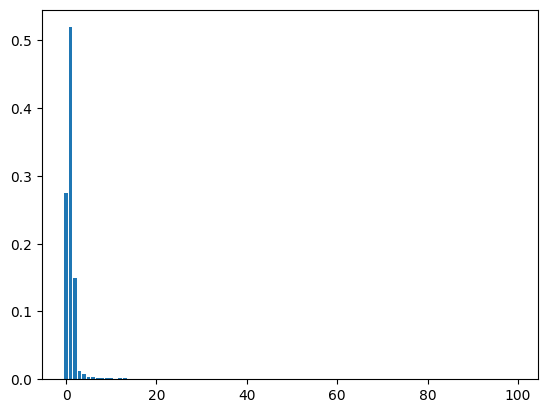

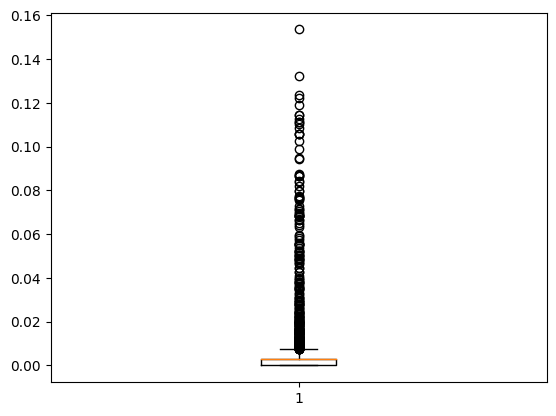

Filter:   0%|          | 0/7500 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/250 [00:00<?, ? examples/s]

[WARNING|modeling_utils.py:3331] 2023-08-12 13:22:59,794 >> Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running tokenizer on dataset:   0%|          | 0/250 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
50,0.616300,0.383446,0.755000
100,0.449900,0.262982,0.919000
150,0.183100,0.398215,0.912000
200,0.101800,0.327358,0.923000
250,0.041700,0.503059,0.914000
300,0.012700,0.812946,0.883000
350,0.024200,0.557577,0.919000
400,0.007900,0.578082,0.921000
450,0.000400,0.595787,0.921000
500,0.015200,0.609851,0.918000


***** train metrics *****
  epoch                    =      31.25
  total_flos               =   478688GF
  train_loss               =     0.1453
  train_runtime            = 0:05:08.28
  train_samples            =        250
  train_samples_per_second =      25.95
  train_steps_per_second   =      1.622


***** eval metrics *****
  epoch                   =      31.25
  eval_accuracy           =      0.918
  eval_loss               =     0.6099
  eval_runtime            = 0:00:07.38
  eval_samples            =       1000
  eval_samples_per_second =    135.432
  eval_steps_per_second   =      8.532
*** predictions: [[ 4.1462297 -4.2731657]
 [ 4.1778564 -4.2922196]
 [ 4.2028866 -4.345722 ]
 ...
 [-4.366693   4.770375 ]
 [ 4.1662636 -4.3313613]
 [-4.285259   4.575785 ]]
*** predictions_len data: 1500


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Metrics Report:

Accuracy: 0.902
Confusion Matrix:
[[1005   86]
 [  61  348]]
Precision: 0.8018433179723502
Recall: 0.8508557457212714
F1-score: 0.8256227758007119
Current Active Learning Iteration: 2


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/20 [00:00<?, ?it/s]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   1    |   15    |   0.664629  


  5%|▌         | 1/20 [01:01<19:26, 61.40s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   2    |   15    |   0.633803  


 10%|█         | 2/20 [02:02<18:21, 61.17s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   3    |   15    |   0.607432  


 15%|█▌        | 3/20 [03:03<17:16, 60.96s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   4    |   15    |   0.585879  


 20%|██        | 4/20 [04:03<16:14, 60.89s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   5    |   15    |   0.576718  


 25%|██▌       | 5/20 [05:05<15:14, 60.97s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   6    |   15    |   0.618561  


 30%|███       | 6/20 [06:06<14:14, 61.07s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   7    |   15    |   0.531048  


 35%|███▌      | 7/20 [07:07<13:13, 61.04s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   8    |   15    |   0.505924  


 40%|████      | 8/20 [08:08<12:11, 60.96s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   9    |   15    |   0.425046  


 45%|████▌     | 9/20 [09:09<11:11, 61.04s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  10    |   15    |   0.342935  


 50%|█████     | 10/20 [10:10<10:10, 61.04s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  11    |   15    |   0.346337  


 55%|█████▌    | 11/20 [11:11<09:09, 61.04s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  12    |   15    |   0.319087  


 60%|██████    | 12/20 [12:12<08:07, 60.95s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  13    |   15    |   0.287281  


 65%|██████▌   | 13/20 [13:13<07:06, 60.99s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  14    |   15    |   0.262013  


 70%|███████   | 14/20 [14:14<06:06, 61.04s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  15    |   15    |   0.256522  


 75%|███████▌  | 15/20 [15:15<05:05, 61.08s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  16    |   15    |   0.251245  


 80%|████████  | 16/20 [16:16<04:03, 60.95s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  17    |   15    |   0.251694  


 85%|████████▌ | 17/20 [17:17<03:03, 61.00s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  18    |   15    |   0.243249  


 90%|█████████ | 18/20 [18:18<02:02, 61.05s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  19    |   15    |   0.253135  


 95%|█████████▌| 19/20 [19:19<01:01, 61.09s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  20    |   15    |   0.242943  


100%|██████████| 20/20 [20:20<00:00, 61.01s/it]


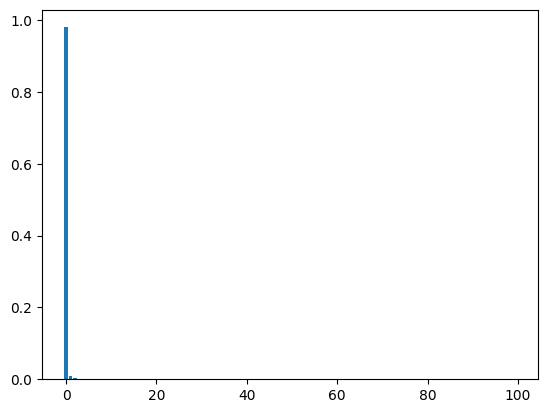

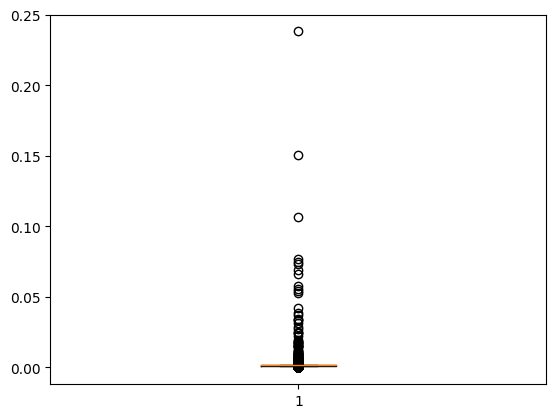

Filter:   0%|          | 0/7500 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/350 [00:00<?, ? examples/s]

[WARNING|modeling_utils.py:3331] 2023-08-12 13:50:56,210 >> Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running tokenizer on dataset:   0%|          | 0/350 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
50,0.645100,0.301737,0.900000
100,0.382200,0.224625,0.931000
150,0.219000,0.213205,0.946000
200,0.080500,0.349369,0.934000
250,0.053000,0.416219,0.937000
300,0.034500,0.451891,0.936000
350,0.019000,0.451239,0.939000
400,0.018600,0.465632,0.939000
450,0.000500,0.466784,0.938000
500,0.000600,0.463306,0.943000


***** train metrics *****
  epoch                    =      22.73
  total_flos               =   487387GF
  train_loss               =     0.1453
  train_runtime            = 0:05:10.97
  train_samples            =        350
  train_samples_per_second =     25.726
  train_steps_per_second   =      1.608


***** eval metrics *****
  epoch                   =      22.73
  eval_accuracy           =      0.943
  eval_loss               =     0.4633
  eval_runtime            = 0:00:07.32
  eval_samples            =       1000
  eval_samples_per_second =    136.498
  eval_steps_per_second   =      8.599
*** predictions: [[ 4.439555  -4.620221 ]
 [ 4.4268174 -4.661256 ]
 [ 4.337053  -4.609508 ]
 ...
 [-4.2574706  4.5571194]
 [ 4.413951  -4.628146 ]
 [-4.492778   4.7555923]]
*** predictions_len data: 1500


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Metrics Report:

Accuracy: 0.9233333333333333
Confusion Matrix:
[[1038   53]
 [  62  347]]
Precision: 0.8675
Recall: 0.8484107579462102
F1-score: 0.857849196538937
Current Active Learning Iteration: 3


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/20 [00:00<?, ?it/s]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   1    |   21    |   0.690632  


  5%|▌         | 1/20 [01:09<21:54, 69.17s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   2    |   21    |   0.677739  


 10%|█         | 2/20 [02:18<20:41, 68.98s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   3    |   21    |   0.682800  


 15%|█▌        | 3/20 [03:26<19:28, 68.72s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   4    |   21    |   0.686819  


 20%|██        | 4/20 [04:34<18:18, 68.63s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   5    |   21    |   0.666132  


 25%|██▌       | 5/20 [05:43<17:09, 68.61s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   6    |   21    |   0.655975  


 30%|███       | 6/20 [06:52<16:00, 68.58s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   7    |   21    |   0.641234  


 35%|███▌      | 7/20 [08:00<14:51, 68.55s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   8    |   21    |   0.590608  


 40%|████      | 8/20 [09:09<13:42, 68.53s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   9    |   21    |   0.565207  


 45%|████▌     | 9/20 [10:17<12:34, 68.56s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  10    |   21    |   0.534577  


 50%|█████     | 10/20 [11:26<11:26, 68.65s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  11    |   21    |   0.460899  


 55%|█████▌    | 11/20 [12:35<10:18, 68.75s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  12    |   21    |   0.370704  


 60%|██████    | 12/20 [13:44<09:10, 68.80s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  13    |   21    |   0.498743  


 65%|██████▌   | 13/20 [14:52<08:01, 68.75s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  14    |   21    |   0.363290  


 70%|███████   | 14/20 [16:01<06:52, 68.68s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  15    |   21    |   0.317633  


 75%|███████▌  | 15/20 [17:10<05:43, 68.71s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  16    |   21    |   0.282908  


 80%|████████  | 16/20 [18:19<04:35, 68.78s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  17    |   21    |   0.254617  


 85%|████████▌ | 17/20 [19:28<03:26, 68.82s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  18    |   21    |   0.245057  


 90%|█████████ | 18/20 [20:36<02:17, 68.80s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  19    |   21    |   0.230416  


 95%|█████████▌| 19/20 [21:45<01:08, 68.73s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  20    |   21    |   0.214349  


100%|██████████| 20/20 [22:54<00:00, 68.71s/it]


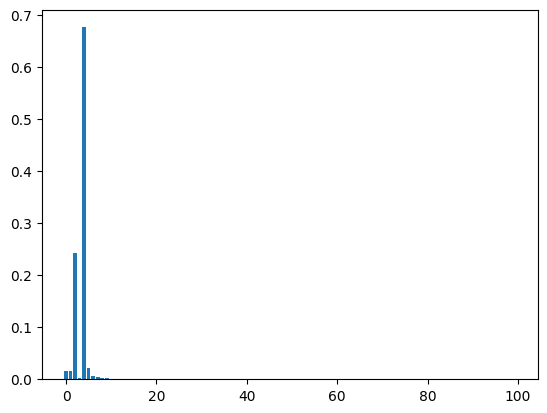

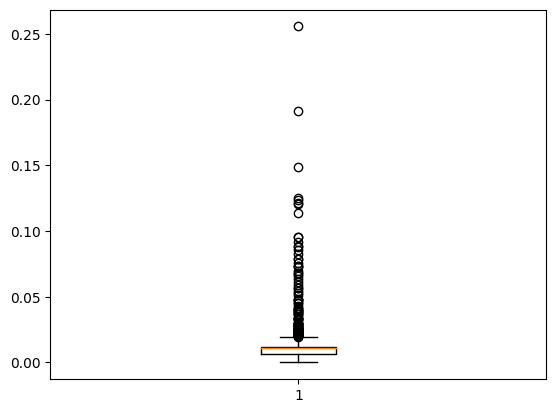

Filter:   0%|          | 0/7500 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/450 [00:00<?, ? examples/s]

[WARNING|modeling_utils.py:3331] 2023-08-12 14:21:32,431 >> Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running tokenizer on dataset:   0%|          | 0/450 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
50,0.688000,0.648020,0.732000
100,0.652200,0.432137,0.849000
150,0.482300,0.262751,0.921000
200,0.342000,0.252696,0.930000
250,0.209500,0.234112,0.933000
300,0.128500,0.336267,0.923000
350,0.113900,0.355421,0.933000
400,0.076600,0.374561,0.935000
450,0.066200,0.371946,0.935000
500,0.062400,0.372083,0.936000


***** train metrics *****
  epoch                    =      17.24
  total_flos               =   475502GF
  train_loss               =     0.2822
  train_runtime            = 0:05:01.67
  train_samples            =        450
  train_samples_per_second =     26.519
  train_steps_per_second   =      1.657


***** eval metrics *****
  epoch                   =      17.24
  eval_accuracy           =      0.936
  eval_loss               =     0.3721
  eval_runtime            = 0:00:07.27
  eval_samples            =       1000
  eval_samples_per_second =    137.365
  eval_steps_per_second   =      8.654
*** predictions: [[ 2.7431684 -2.7238042]
 [ 3.3046587 -3.503442 ]
 [ 3.0858846 -3.1373353]
 ...
 [-3.668657   3.9113288]
 [ 2.4097784 -2.423069 ]
 [-3.5459769  3.7289553]]
*** predictions_len data: 1500


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Metrics Report:

Accuracy: 0.912
Confusion Matrix:
[[1018   73]
 [  59  350]]
Precision: 0.8274231678486997
Recall: 0.8557457212713936
F1-score: 0.8413461538461537
Current Active Learning Iteration: 4


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/20 [00:00<?, ?it/s]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   1    |   28    |   0.673466  


  5%|▌         | 1/20 [01:16<24:21, 76.94s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   2    |   28    |   0.671154  


 10%|█         | 2/20 [02:33<23:01, 76.77s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   3    |   28    |   0.667075  


 15%|█▌        | 3/20 [03:50<21:46, 76.83s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   4    |   28    |   0.661899  


 20%|██        | 4/20 [05:07<20:28, 76.80s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   5    |   28    |   0.676179  


 25%|██▌       | 5/20 [06:23<19:09, 76.61s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   6    |   28    |   0.670789  


 30%|███       | 6/20 [07:39<17:50, 76.47s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   7    |   28    |   0.670225  


 35%|███▌      | 7/20 [08:55<16:32, 76.35s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   8    |   28    |   0.674223  


 40%|████      | 8/20 [10:11<15:15, 76.28s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   9    |   28    |   0.668232  


 45%|████▌     | 9/20 [11:28<13:58, 76.23s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  10    |   28    |   0.681744  


 50%|█████     | 10/20 [12:44<12:42, 76.25s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  11    |   28    |   0.654036  


 55%|█████▌    | 11/20 [14:00<11:26, 76.30s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  12    |   28    |   0.672028  


 60%|██████    | 12/20 [15:17<10:10, 76.29s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  13    |   28    |   0.670528  


 65%|██████▌   | 13/20 [16:33<08:53, 76.27s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  14    |   28    |   0.680653  


 70%|███████   | 14/20 [17:49<07:37, 76.25s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  15    |   28    |   0.671812  


 75%|███████▌  | 15/20 [19:05<06:21, 76.27s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  16    |   28    |   0.659124  


 80%|████████  | 16/20 [20:22<05:05, 76.32s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  17    |   28    |   0.675297  


 85%|████████▌ | 17/20 [21:38<03:48, 76.31s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  18    |   28    |   0.671167  


 90%|█████████ | 18/20 [22:54<02:32, 76.29s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  19    |   28    |   0.670851  


 95%|█████████▌| 19/20 [24:10<01:16, 76.26s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  20    |   28    |   0.675615  


100%|██████████| 20/20 [25:27<00:00, 76.36s/it]


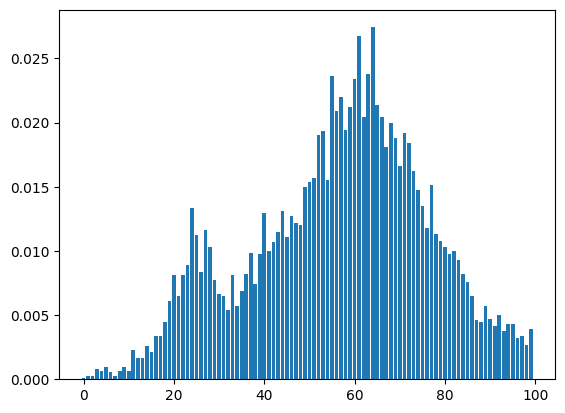

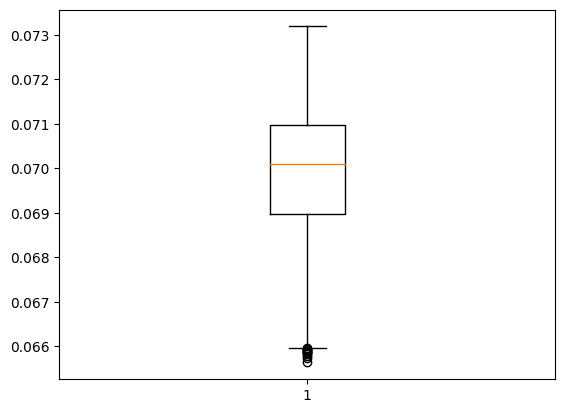

Filter:   0%|          | 0/7500 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/550 [00:00<?, ? examples/s]

[WARNING|modeling_utils.py:3331] 2023-08-12 14:54:32,391 >> Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running tokenizer on dataset:   0%|          | 0/550 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
50,0.666300,0.515957,0.732000
100,0.581400,0.307659,0.904000
150,0.370000,0.191908,0.931000
200,0.224100,0.228456,0.939000
250,0.161800,0.397502,0.919000
300,0.083000,0.331231,0.942000
350,0.099700,0.394910,0.932000
400,0.040600,0.460623,0.921000
450,0.051400,0.357828,0.944000
500,0.051700,0.393255,0.933000


***** train metrics *****
  epoch                    =      14.29
  total_flos               =   481506GF
  train_loss               =      0.233
  train_runtime            = 0:05:04.16
  train_samples            =        550
  train_samples_per_second =     26.302
  train_steps_per_second   =      1.644


***** eval metrics *****
  epoch                   =      14.29
  eval_accuracy           =      0.933
  eval_loss               =     0.3933
  eval_runtime            = 0:00:07.28
  eval_samples            =       1000
  eval_samples_per_second =    137.199
  eval_steps_per_second   =      8.644
*** predictions: [[ 3.4172564 -3.308077 ]
 [ 3.6752822 -3.7319303]
 [ 3.6669595 -3.65998  ]
 ...
 [-3.7373457  4.2148743]
 [ 3.5574062 -3.5419543]
 [-3.595445   3.8553762]]
*** predictions_len data: 1500


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Metrics Report:

Accuracy: 0.9073333333333333
Confusion Matrix:
[[999  92]
 [ 47 362]]
Precision: 0.7973568281938326
Recall: 0.8850855745721271
F1-score: 0.8389339513325608
Current Active Learning Iteration: 5


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/20 [00:00<?, ?it/s]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   1    |   34    |   0.685141  


  5%|▌         | 1/20 [01:24<26:52, 84.88s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   2    |   34    |   0.655624  


 10%|█         | 2/20 [02:49<25:24, 84.67s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   3    |   34    |   0.581779  


 15%|█▌        | 3/20 [04:13<23:58, 84.60s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   4    |   34    |   0.536634  


 20%|██        | 4/20 [05:38<22:31, 84.48s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   5    |   34    |   0.448175  


 25%|██▌       | 5/20 [07:02<21:05, 84.38s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   6    |   34    |   0.402480  


 30%|███       | 6/20 [08:26<19:40, 84.30s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   7    |   34    |   0.355350  


 35%|███▌      | 7/20 [09:50<18:15, 84.24s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   8    |   34    |   0.340491  


 40%|████      | 8/20 [11:14<16:50, 84.25s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   9    |   34    |   0.310646  


 45%|████▌     | 9/20 [12:39<15:26, 84.26s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  10    |   34    |   0.301320  


 50%|█████     | 10/20 [14:03<14:02, 84.23s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  11    |   34    |   0.280467  


 55%|█████▌    | 11/20 [15:27<12:37, 84.21s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  12    |   34    |   0.267089  


 60%|██████    | 12/20 [16:51<11:13, 84.19s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  13    |   34    |   0.269157  


 65%|██████▌   | 13/20 [18:15<09:49, 84.20s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  14    |   34    |   0.239943  


 70%|███████   | 14/20 [19:40<08:25, 84.23s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  15    |   34    |   0.243612  


 75%|███████▌  | 15/20 [21:04<07:01, 84.22s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  16    |   34    |   0.248004  


 80%|████████  | 16/20 [22:28<05:36, 84.18s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  17    |   34    |   0.264798  


 85%|████████▌ | 17/20 [23:52<04:12, 84.27s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  18    |   34    |   0.235083  


 90%|█████████ | 18/20 [25:17<02:48, 84.36s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  19    |   34    |   0.256838  


 95%|█████████▌| 19/20 [26:41<01:24, 84.34s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  20    |   34    |   0.249445  


100%|██████████| 20/20 [28:06<00:00, 84.31s/it]


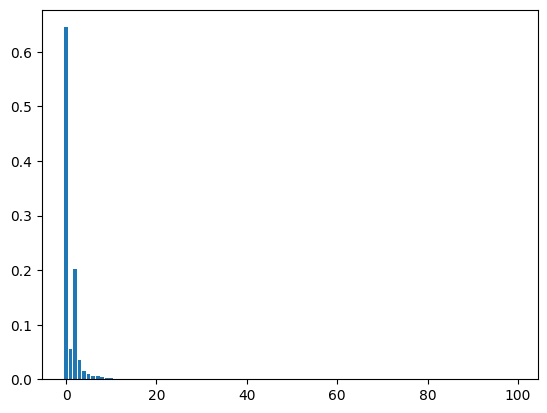

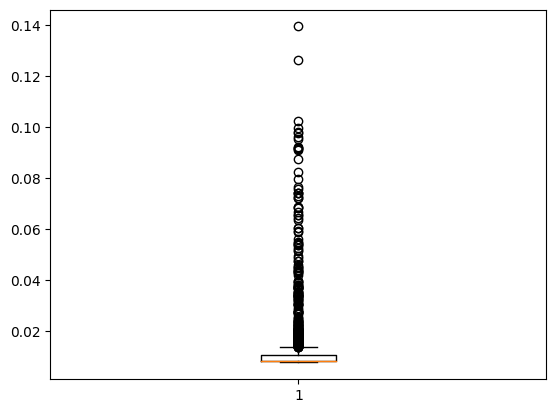

Filter:   0%|          | 0/7500 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/650 [00:00<?, ? examples/s]

[WARNING|modeling_utils.py:3331] 2023-08-12 15:30:12,023 >> Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running tokenizer on dataset:   0%|          | 0/650 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
50,0.678800,0.434029,0.861000
100,0.552800,0.241021,0.919000
150,0.370300,0.264825,0.929000
200,0.287300,0.255589,0.919000
250,0.156900,0.372804,0.909000
300,0.147200,0.305194,0.939000
350,0.151600,0.312742,0.939000
400,0.063700,0.395619,0.928000
450,0.037200,0.343533,0.942000
500,0.065800,0.384670,0.934000


***** train metrics *****
  epoch                    =       12.2
  total_flos               =   485671GF
  train_loss               =     0.2512
  train_runtime            = 0:05:06.15
  train_samples            =        650
  train_samples_per_second =      26.13
  train_steps_per_second   =      1.633


***** eval metrics *****
  epoch                   =       12.2
  eval_accuracy           =      0.934
  eval_loss               =     0.3847
  eval_runtime            = 0:00:07.29
  eval_samples            =       1000
  eval_samples_per_second =    137.155
  eval_steps_per_second   =      8.641
*** predictions: [[ 3.2970798 -3.6193707]
 [ 3.2544734 -3.615477 ]
 [ 3.3373704 -3.6312482]
 ...
 [-3.4837604  4.030213 ]
 [ 3.3296506 -3.6665442]
 [-3.440465   3.986577 ]]
*** predictions_len data: 1500


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Metrics Report:

Accuracy: 0.9166666666666666
Confusion Matrix:
[[1010   81]
 [  44  365]]
Precision: 0.8183856502242153
Recall: 0.8924205378973105
F1-score: 0.8538011695906432
Current Active Learning Iteration: 6


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/20 [00:00<?, ?it/s]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   1    |   40    |   0.701191  


  5%|▌         | 1/20 [01:32<29:22, 92.77s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   2    |   40    |   0.680861  


 10%|█         | 2/20 [03:05<27:46, 92.58s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   3    |   40    |   0.681456  


 15%|█▌        | 3/20 [04:37<26:13, 92.53s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   4    |   40    |   0.668694  


 20%|██        | 4/20 [06:09<24:36, 92.29s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   5    |   40    |   0.666827  


 25%|██▌       | 5/20 [07:42<23:05, 92.35s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   6    |   40    |   0.654476  


 30%|███       | 6/20 [09:14<21:32, 92.34s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   7    |   40    |   0.631067  


 35%|███▌      | 7/20 [10:46<19:59, 92.24s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   8    |   40    |   0.622133  


 40%|████      | 8/20 [12:18<18:27, 92.26s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
   9    |   40    |   0.577927  


 45%|████▌     | 9/20 [13:51<16:55, 92.30s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  10    |   40    |   0.576540  


 50%|█████     | 10/20 [15:23<15:22, 92.22s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  11    |   40    |   0.547436  


 55%|█████▌    | 11/20 [16:55<13:49, 92.13s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  12    |   40    |   0.508062  


 60%|██████    | 12/20 [18:27<12:17, 92.17s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  13    |   40    |   0.506568  


 65%|██████▌   | 13/20 [19:59<10:45, 92.21s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  14    |   40    |   0.509320  


 70%|███████   | 14/20 [21:31<09:12, 92.15s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  15    |   40    |   0.504617  


 75%|███████▌  | 15/20 [23:03<07:40, 92.10s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  16    |   40    |   0.507933  


 80%|████████  | 16/20 [24:35<06:08, 92.12s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  17    |   40    |   0.503739  


 85%|████████▌ | 17/20 [26:08<04:36, 92.20s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  18    |   40    |   0.509497  


 90%|█████████ | 18/20 [27:40<03:04, 92.13s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  19    |   40    |   0.510015  


 95%|█████████▌| 19/20 [29:12<01:32, 92.06s/it]


 Epoch  |  Batch  |  Train Loss 
---------------------------------------------
  20    |   40    |   0.509360  


100%|██████████| 20/20 [30:44<00:00, 92.22s/it]


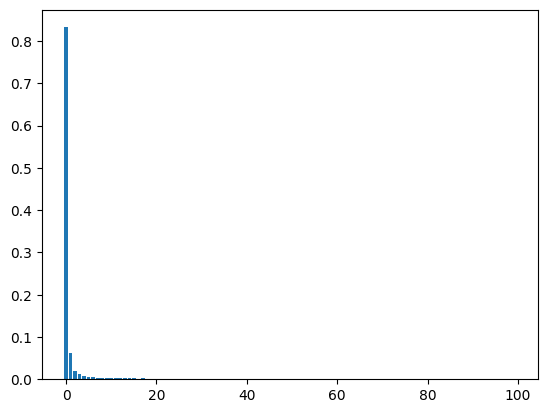

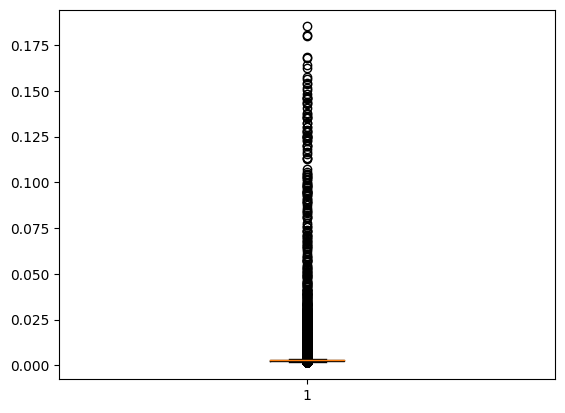

Filter:   0%|          | 0/7500 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/750 [00:00<?, ? examples/s]

[WARNING|modeling_utils.py:3331] 2023-08-12 16:08:34,651 >> Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running tokenizer on dataset:   0%|          | 0/750 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
50,0.680200,0.559908,0.732000
100,0.624400,0.307241,0.910000
150,0.472900,0.199648,0.923000
200,0.414500,0.201060,0.939000
250,0.332700,0.214592,0.932000
300,0.257600,0.268264,0.923000
350,0.224500,0.227055,0.945000
400,0.119500,0.267749,0.939000
450,0.086300,0.298478,0.940000
500,0.110500,0.309657,0.939000


***** train metrics *****
  epoch                    =      10.64
  total_flos               =   488857GF
  train_loss               =     0.3323
  train_runtime            = 0:05:08.06
  train_samples            =        750
  train_samples_per_second =     25.968
  train_steps_per_second   =      1.623


***** eval metrics *****
  epoch                   =      10.64
  eval_accuracy           =      0.939
  eval_loss               =     0.3097
  eval_runtime            = 0:00:07.35
  eval_samples            =       1000
  eval_samples_per_second =    135.963
  eval_steps_per_second   =      8.566
*** predictions: [[ 2.612588  -2.4850874]
 [ 2.9020054 -2.909511 ]
 [ 2.738504  -2.6524396]
 ...
 [-3.31012    3.790153 ]
 [ 2.468087  -2.36041  ]
 [-3.3267856  3.7568386]]
*** predictions_len data: 1500


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Metrics Report:

Accuracy: 0.9206666666666666
Confusion Matrix:
[[1016   75]
 [  44  365]]
Precision: 0.8295454545454546
Recall: 0.8924205378973105
F1-score: 0.8598351001177856


In [43]:
# model, head = run_discrepancy_sampling()
run_discrepancy_sampling()

In [44]:
torch.save(model, "./results/model.pt")
torch.save(head, "./results/head.pt")

NameError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! mv ./results/discrepancy/ ./drive/MyDrive/Thesis/Data/experiments/

### Test Model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, do_lower_case=True)

In [ ]:
def is_political(sentence, base_model, classifier):
    input = tokenizer.encode_plus(
                sentence,                      # Sentence to encode.
                add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                max_length = 256,           # Pad & truncate all sentences.
                pad_to_max_length = True,
                return_attention_mask = True,   # Construct attn. masks.
                return_tensors = 'pt',     # Return pytorch tensors.
        ).to(DEVICE)
    outputs = base_model(**input)
    last_hidden_state_cls = outputs[0][:, 0, :].to(DEVICE)

    logits = classifier(last_hidden_state_cls)

    is_political = torch.argmax(logits, dim=1).flatten().item()

    if is_political == 0:
        return "👎"
    else:
        return "👍"

In [ ]:
is_political("زندانیان سیاسی را آزاد کنید.", base_model=model, classifier=head)

In [ ]:
is_political("راهمپیمایی امروز نشان دهنده قدرت نظام بود.", base_model=model, classifier=head)

In [ ]:
is_political("زندانیان جرائم سیاسی را باید آزاد کرد", base_model=model, classifier=head)